# 📊 Backtesting Naïve Trading Strategies

## Introduction
This notebook explores **backtesting simple trading strategies**, focusing on rule-based approaches such as **moving average crossovers**. We aim to assess the effectiveness of these strategies using historical market data.

To achieve this, we develop a modular framework with two key components:
- **Strategy Class**: Defines trading rules and generates buy/sell signals.
- **Backtest Class**: Simulates trade execution and evaluates trading performance.

## ⚙️ Strategy Class
The `Strategy` class serves as the foundation for implementing various trading strategies. It requires the user to define a method for generating signals based on market data. This allows flexibility in testing different rule-based approaches.

## 🔍 Backtest Engine
The `Backtest` class executes the strategy and tracks performance. It:
- Uses trading signals to determine when to enter and exit positions.
- Integrate Fees as **slippage** and **brokerage**.
- Allows visualization of the **strategy’s performance over different bars**.

This setup allows us to test and refine different trading strategies efficiently.

*Notes : The First of the Notebook is about defining functions and classes, feel free to go directly to the results parts*

In [1]:
import sys
sys.path.append("../")
import Data as dt #! this module is not available in the repository, you can use whatever data you have

import pandas as pd
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tabulate import tabulate

---
## **Let's define our base model to hold the different strategies**

In [2]:
class Strategy(ABC):
    def __init__(self):
        # ======= Adapt columns name to the available data / operational consideration =======
        self.date_name = "date"
        self.bid_open_name = "open"
        self.ask_open_name = "open"
        
        # ======= Store Data used for the strategy =======
        self.data = None
        self.processed_data = None
    
    #*____________________________________________________________________________________ #
    def set_names(self, date_name: str, bid_open_name: str, ask_open_name: str):
        """
        Set the names of the columns used in the data, it is important to ensure the operations are done using the correct price. 
        For daily data, it is common to use the open or close price for both bid and ask. The bid-ask spread is usually estimated as a slippage cost.
        
            - date_name (str) : name of the column containing the dates
            - bid_open_name (str) : name of the column containing the bid open prices at which the strategy will operate
            - ask_open_name (str) : name of the column containing the ask open prices at which the strategy will operate
        """
        self.date_name = date_name
        self.bid_open_name = bid_open_name
        self.ask_open_name = ask_open_name
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def set_params(self):
        """This method should be used to set the different parameters of the model."""
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def load_data(self):
        """This method should be used to load the data."""
        pass

    #*____________________________________________________________________________________ #
    @abstractmethod
    def process_data(self):
        """
        This method should be used to process the data : normalization, feature engineering, etc.
        It is expected to output a list of pd.DataFrame containing the processed data, each element of the list will then be used independtly to predict the signals.
        For daily data, returning a list containing a unique element is enough. Different elements can be used to avoid overnight bias when operating only intraday.
        """
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def fit(self):
        """
        This method should be used to train the model, optimize hyperparameters and so on.
        It does not explicitly split samples, this has to be done by the user before calling this method.
        """
        pass
    
    #*____________________________________________________________________________________ #
    @abstractmethod
    def predict(self):
        """
        This method should be used to predict the signals.
        It is expected to return a pd.DataFrame containing the necessary data to compute the operations (signals, price, date, etc.).
        """
        pass

    #*____________________________________________________________________________________ #
    def operate(self, df: pd.DataFrame):
        """
        This method is common to all strategies and is used to extract the operations from the signals.
        The outputs are the operations (each line corresponds to a different trade) and the signals (each line corresponds to a bar with the associated signal) DataFrames.
        
            - df (pd.DataFrame) : DataFrame containing the data used to extract the operations
        """
        # ======= I. Extract signals =======
        signals_df = self.predict(df=df)
        
        # ======= II. Objects initialization before extracting operations =======
        operations_df = pd.DataFrame(columns=['ID', 'Side', 'Entry_Date', 'Entry_Price', 'Exit_Date', 'Exit_Price', 'PnL'])
        
        # II.1 Set first and last signal to 0 to ensure that the operations are closed
        signals_df.reset_index(drop=True, inplace=True)

        signals_df.loc[0, "signal"] = 0
        signals_df.loc[len(signals_df) - 1, "signal"] = 0
        signals_df.loc[len(signals_df) - 2, "signal"] = 0

        # II.2 Extract the Signal Change and the Entry Points
        signals_df["Signal Change"] = signals_df["signal"].diff()
        signals_df["Signal Change"] = signals_df["Signal Change"].shift(1) #! Shifted to avoid look-ahead bias

        entry_points = signals_df[signals_df["Signal Change"] != 0].copy()
        nb_entry = len(entry_points)
        
        # ======= III. Create an Operation for each entry point =======
        sequential_id = 0
        for idx in range(nb_entry - 1):
            # III.1 Extracting rows
            current_row = entry_points.iloc[idx]
            next_row = entry_points.iloc[idx + 1]
            previous_row = signals_df.iloc[current_row.name - 1]

            # III.2 Extract Information for a Long Operation
            if (current_row["Signal Change"] > 0 and previous_row["signal"] == 1):
                side = 1
                entry_date = current_row[self.date_name]
                entry_price = current_row[self.ask_open_name]
                exit_date = next_row[self.date_name]
                exit_price = next_row[self.bid_open_name]
                pnl = (exit_price - entry_price)

            # III.3 Extract Information for a Short Operation
            elif (current_row["Signal Change"] < 0 and previous_row["signal"] == -1):
                side = -1
                entry_date = current_row[self.date_name]
                entry_price = current_row[self.bid_open_name]
                exit_date = next_row[self.date_name]
                exit_price = next_row[self.ask_open_name]
                pnl = (entry_price - exit_price)

            else:
                continue

            # III.4 Append Operation to the DataFrame
            operations_df.loc[sequential_id] = [
                sequential_id,
                side,
                entry_date,
                entry_price,
                exit_date,
                exit_price,
                pnl,
            ]

            # --- New sequential id for the next loop iteration ---
            sequential_id += 1
        
        return operations_df, signals_df



---
## **Now let's define the Backtest Framework**
### *It will take a Strategy as input so every strategy we design could be tested systematically*

In [3]:
"""
We first define some functions to compute the performance metrics of a given strategy.
"""

def get_distribution(returns_series: pd.Series, frequence: str = "daily"):
    """
    - Expected Return: The annualized mean return, indicating average performance.
    - Volatility: Standard deviation of returns, representing total risk.
    - Downside Deviation: Standard deviation of negative returns, used in risk-adjusted metrics like Sortino Ratio.
    - Median Return: The median of returns, a measure of central tendency.
    - Skew & Kurtosis: Describe the distribution shape, with skew indicating asymmetry and kurtosis indicating tail heaviness.
    """
    # ======= I. Get the right frequence =======
    frequence_dict = {"daily": 252, "5m": 19656, "1m": 98280}
    adjusted_frequence = frequence_dict[frequence]
    
    # ======= II. Compute the statistics =======
    expected_return = returns_series.mean() * adjusted_frequence
    volatility = returns_series.std() * np.sqrt(adjusted_frequence)
    downside_deviation = returns_series[returns_series < 0].std() * np.sqrt(adjusted_frequence) if returns_series[returns_series < 0].sum() != 0 else 0
    median_return = returns_series.median() * adjusted_frequence
    skew = returns_series.skew()
    kurtosis = returns_series.kurtosis()
    
    # ======= III. Store the statistics =======
    distribution_stats = {
        "expected_return": expected_return,
        "volatility": volatility,
        "downside_deviation": downside_deviation,
        "median_return": median_return,
        "skew": skew,
        "kurtosis": kurtosis,
    }
    
    return distribution_stats

# ____________________________________________________________________________________ #
def get_risk_measures(returns_series: pd.Series):
    """
    - Maximum Drawdown: Largest observed loss from peak to trough, a measure of downside risk.
    - Max Drawdown Duration: Longest period to recover from drawdown, indicating risk recovery time.
    - VaR 95 and CVaR 95: Value at Risk and Conditional Value at Risk at 95%, giving the maximum and average expected losses in worst-case scenarios.
    """
    # ======= I. Compute the Cumulative returns =======    
    cumulative_returns = (1 + returns_series).cumprod()
    
    # ======= II. Compute the statistics =======
    # ------ Maximum Drawdown and Duration
    running_max = cumulative_returns.cummax().replace(0, 1e-10)
    drawdown = (cumulative_returns / running_max) - 1
    drawdown_durations = (drawdown < 0).astype(int).groupby((drawdown == 0).cumsum()).cumsum()

    maximum_drawdown = drawdown.min()
    max_drawdown_duration = drawdown_durations.max()

    # ------ Value at Risk and Conditional Value at Risk
    var_95 = returns_series.quantile(0.05)
    cvar_95 = returns_series[returns_series <= var_95].mean()
    
    # ======= III. Store the statistics =======
    risk_stats = {
        "drawdown": drawdown,
        "maximum_drawdown": maximum_drawdown,
        "max_drawdown_duration": max_drawdown_duration,
        "var_95": var_95,
        "cvar_95": cvar_95,
    }
    
    return risk_stats

# ____________________________________________________________________________________ #
def get_market_sensitivity(returns_series: pd.Series, market_returns: pd.Series, frequence: str = "daily"):
    """
    - Beta: Sensitivity to market movements.
    - Alpha: Risk-adjusted return above the market return.
    - Upside/Downside Capture Ratios: Percent of market gains or losses captured by the investment.
    - Tracking Error: Volatility of return differences from the market.
    """
    # ======= I. Get the right frequence =======
    frequence_dict = {"daily": 252, "5m": 19656, "1m": 98280}
    adjusted_frequence = frequence_dict[frequence]
    
    # ======= II. Compute the statistics =======
    # ------ Beta and Alpha (Jensens's)
    beta = returns_series.cov(market_returns) / market_returns.var()
    alpha = returns_series.mean() * adjusted_frequence - beta * (market_returns.mean() * adjusted_frequence)
    
    # ------ Capture Ratios
    upside_capture = returns_series[market_returns > 0].mean() / market_returns[market_returns > 0].mean()
    downside_capture = returns_series[market_returns < 0].mean() / market_returns[market_returns < 0].mean()

    # ------ Tracking Error
    tracking_error = returns_series.sub(market_returns).std() * np.sqrt(adjusted_frequence)
    
    # ======= III. Store the statistics =======
    market_sensitivity_stats = {
        "beta": beta,
        "alpha": alpha,
        "upside_capture": upside_capture,
        "downside_capture": downside_capture,
        "tracking_error": tracking_error,
    }
    
    return market_sensitivity_stats

# ____________________________________________________________________________________ #
def get_performance_measures(returns_series: pd.Series, market_returns: pd.Series, risk_free_rate: float = 0.0, frequence: str = "daily"):
    """
    - Sharpe Ratio: Risk-adjusted returns per unit of volatility.
    - Sortino Ratio: Risk-adjusted return accounting only for downside volatility.
    - Treynor Ratio: Return per unit of systematic (market) risk.
    - Information Ratio: Excess return per unit of tracking error.
    - Sterling Ratio: Return per unit of average drawdown.
    - Calmar Ratio: Return per unit of maximum drawdown.
    """
    # ======= I. Get the right frequence =======
    frequence_dict = {"daily": 252, "5m": 19656, "1m": 98280}
    adjusted_frequence = frequence_dict[frequence]
    
    # ======= II. Extract Statistics =======
    distribution_stats = get_distribution(returns_series, frequence)
    expected_return = distribution_stats["expected_return"]
    volatility = distribution_stats["volatility"]
    downside_deviation = distribution_stats["downside_deviation"]
    
    risk_stats = get_risk_measures(returns_series)
    drawdown = risk_stats["drawdown"]
    maximum_drawdown = risk_stats["maximum_drawdown"]
    
    market_sensitivity_stats = get_market_sensitivity(returns_series, market_returns, frequence)
    beta = market_sensitivity_stats["beta"]
    tracking_error = market_sensitivity_stats["tracking_error"]
    
    # ======= III. Compute the ratios =======
    # ------ Sharpe, Sortino, Treynor, and Information Ratios
    sharpe_ratio = (expected_return - risk_free_rate) / volatility if volatility != 0 else 0
    sortino_ratio = expected_return / downside_deviation if downside_deviation != 0 else 0
    treynor_ratio = expected_return / beta if beta != 0 else 0
    information_ratio = (expected_return - market_returns.mean() * adjusted_frequence) / tracking_error if tracking_error != 0 else 0

    # ------ Sterling, and Calmar Ratios
    average_drawdown = abs(drawdown[drawdown < 0].mean()) if drawdown[drawdown < 0].sum() != 0 else 0
    sterling_ratio = (expected_return - risk_free_rate) / average_drawdown if average_drawdown != 0 else 0
    calmar_ratio = expected_return / abs(maximum_drawdown) if maximum_drawdown != 0 else 0
    
    # ======= IV. Store the statistics =======
    performance_stats = {
        "sharpe_ratio": sharpe_ratio,
        "sortino_ratio": sortino_ratio,
        "treynor_ratio": treynor_ratio,
        "information_ratio": information_ratio,
        "sterling_ratio": sterling_ratio,
        "calmar_ratio": calmar_ratio,
    }
    
    return performance_stats, (distribution_stats, risk_stats, market_sensitivity_stats)


In [4]:
"""
Now we can define a Backtest class. This class will be used to run the backtest of a given strategy.
"""

class Backtest():
    def __init__(self, strategy: Strategy, brokerage_cost: float = 0.0, slippage_cost: float = 0.0):
        # ======= Backtest parameters =======
        self.ticker = None
        self.start_date = None
        self.end_date = None
        self.strategy_params = None
        
        self.brokerage_cost = brokerage_cost
        self.slippage_cost = slippage_cost
        
        self.n_jobs = 1
        
        # ======= Strategy inputs=======
        self.strategy = strategy
        self.data = None
        self.processed_data = None

        # ======= Backtest results =======
        self.signals_dfs = None
        self.operations_dfs = None
        self.full_operations_df = None
        self.full_signals_df = None

    #*____________________________________________________________________________________ #
    def set_computingParams(self, date_name: str, bid_open_name: str, ask_open_name: str, n_jobs: int = 1):
        """
        This method is used to set the different parameters to ensure the correct computation of the operations.
        
            - date_name (str) : name of the column containing the dates
            - bid_open_name (str) : name of the column containing the bid open prices at which the strategy will operate
            - ask_open_name (str) : name of the column containing the ask open prices at which the strategy will operate
            - n_jobs (int) : number of jobs to run in parallel
        """
        self.strategy.set_names(date_name=date_name, bid_open_name=bid_open_name, ask_open_name=ask_open_name)
        self.n_jobs = n_jobs
    
    #*____________________________________________________________________________________ #
    def set_backtestParams(self, ticker: str, start_date: str, end_date: str, strategy_params: dict):
        """
        This method is used to set the different parameters of the backtest.
        
            - ticker (str) : ticker of the asset to backtest
            - start_date (str) : start date of the backtest
            - end_date (str) : end date of the backtest
            - strategy_params (dict) : parameters of the strategy
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.strategy_params = strategy_params
    
    #*____________________________________________________________________________________ #
    def run_strategy(self):
        """
        This method is used to run the strategy and extract the operations.
        """
        # ======= I. Set up Parameters and Data =======
        self.strategy.set_params(**self.strategy_params)
        data = self.strategy.load_data(self.ticker, self.start_date, self.end_date)
        processed_data = self.strategy.process_data()
        
        # I.2 Store the data
        self.data = data
        self.processed_data = processed_data
        
        # ======= II. Run the Strategy =======
        if self.n_jobs > 1:
            #! Be aware that the strategy should be thread-safe and to keep track of the timestamps to reconstitute the operations later.
            operations_dfs, signals_dfs = Parallel(n_jobs=self.n_jobs)(delayed(self.strategy.operate)(data_group) for data_group in processed_data)
        else:
            operations_dfs = []
            signals_dfs = []
            for data_group in processed_data:
                operations_df, signals_df = self.strategy.operate(data_group)
                operations_dfs.append(operations_df)
                signals_dfs.append(signals_df)
        
        full_operations_df = pd.concat(operations_dfs, ignore_index=True, axis=0)
        full_signals_df = pd.concat(signals_dfs, ignore_index=True, axis=0)
        
        return full_operations_df, full_signals_df, operations_dfs, signals_dfs
    
    #*____________________________________________________________________________________ #
    def apply_slippage(self, operations_df: pd.DataFrame):
        """
        This method is used to apply the slippage on the operations by modifying the entry and exit prices.
        
            - operations_df (pd.DataFrame) : DataFrame containing the operations
        """
        # ======= I. Ensure there are operations =======
        adjusted_operations_df = operations_df.copy()
        if operations_df.empty:
            return adjusted_operations_df

        # ======= II. Apply slippage on Entry/Exit prices =======
        # II.1 Adjust entry prices
        adjusted_operations_df["Entry_Price_Adjusted"] = adjusted_operations_df.apply(
            lambda row: row["Entry_Price"] * (1 + self.slippage_cost) if row["Side"] == 1 else row["Entry_Price"] * (1 - self.slippage_cost), axis=1
        )

        # II.2 Adjust exit prices
        adjusted_operations_df["Exit_Price_Adjusted"] = adjusted_operations_df.apply(
            lambda row: row["Exit_Price"] * (1 - self.slippage_cost) if row["Side"] == 1 else row["Exit_Price"] * (1 + self.slippage_cost), axis=1
        )

        # ======= III. Adjust the PnL =======
        adjusted_operations_df["PnL_Adjusted"] = (adjusted_operations_df["Exit_Price_Adjusted"] - adjusted_operations_df["Entry_Price_Adjusted"]) * adjusted_operations_df["Side"]

        return adjusted_operations_df
    
    #*____________________________________________________________________________________ #
    def apply_brokerage(self, operations_df: pd.DataFrame):
        """
        This method is used to apply the brokerage cost on the operations by modifying the PnL.
        
            - operations_df (pd.DataFrame) : DataFrame containing the operations
        """
        # ======= I. Ensure there are operations =======
        adjusted_operations_df = operations_df.copy()
        if operations_df.empty:
            return adjusted_operations_df

        # ======= II. Apply brokerage on PnL =======
        adjusted_operations_df["PnL_Adjusted"] = adjusted_operations_df["PnL_Adjusted"] - (self.brokerage_cost * np.abs(adjusted_operations_df["Entry_Price"]))

        return adjusted_operations_df

    #*____________________________________________________________________________________ #
    def run_backtest(self):
        """
        This method is used to run the backtest.
        """
        # ======= I. Run the Strategy =======
        full_operations_df, full_signals_df, operations_dfs, signals_dfs = self.run_strategy()
        full_operations_df = self.apply_slippage(full_operations_df)
        full_operations_df = self.apply_brokerage(full_operations_df)
        
        # ======= II. Compute the Cumulative Returns : Operations bars =======
        # II.1 Without Fees
        full_operations_df['NoFees_strategy_returns'] = full_operations_df['PnL'] / full_operations_df['Entry_Price']
        full_operations_df['NoFees_strategy_cumret'] = (1 + full_operations_df['NoFees_strategy_returns']).cumprod()
        
        # II.2 With Fees
        full_operations_df['strategy_returns'] = full_operations_df['PnL_Adjusted'] / full_operations_df['Entry_Price']
        full_operations_df['strategy_cumret'] = (1 + full_operations_df['strategy_returns']).cumprod()
        
        # II.3 Buy and Hold
        full_operations_df['BuyAndHold_returns'] = (full_operations_df['Exit_Price'] - full_operations_df['Entry_Price']) / full_operations_df['Entry_Price']
        full_operations_df['BuyAndHold_cumret'] = (1 + full_operations_df['BuyAndHold_returns']).cumprod()

        # ======= III. Compute the Cumulative Returns : Time bars =======
        # For this part, we don't consider the fees and slippage as this computation is relevant only for very low frequency strategies which are less impacted by these costs.
        name_series = self.strategy.ask_open_name
        full_signals_df['BuyAndHold_returns'] = (full_signals_df[name_series].shift(-1) - full_signals_df[name_series]) / full_signals_df[name_series]
        full_signals_df['BuyAndHold_cumret'] = (1 + full_signals_df['BuyAndHold_returns']).cumprod()
        full_signals_df['strategy_returns'] = full_signals_df['signal'].shift(-1) * full_signals_df['BuyAndHold_returns']
        full_signals_df['strategy_cumret'] = (1 + full_signals_df['strategy_returns']).cumprod()

         # ======= IV. Compute statistics =======
        returns_series = full_operations_df['strategy_returns']
        market_returns = full_operations_df['BuyAndHold_returns']
        operation_stats, _ = get_performance_measures(returns_series, market_returns, frequence="daily")

        returns_series = full_signals_df['strategy_returns']
        market_returns = full_signals_df['BuyAndHold_returns']
        time_stats, _ = get_performance_measures(returns_series, market_returns, frequence="daily")
        
        # ======= IV. Store the results =======
        self.full_operations_df = full_operations_df
        self.full_signals_df = full_signals_df
        self.operations_dfs = operations_dfs
        self.signals_dfs = signals_dfs
        
        return full_operations_df, full_signals_df, operation_stats, time_stats
        
    #*____________________________________________________________________________________ #
    def plot_operationsBars(self, by_date: bool = False, BuyAndHold: bool = True, NoFees: bool = True, Fees: bool = True):
        """
        Plots the strategy's cumulative returns based on executed trades.  
        This method intentionally excludes daily portfolio valuation to avoid overestimating result significance.
        """
        # ======= I. Prepare the DataFrame for plotting =======
        plotting_df = self.full_operations_df.copy()

        # ======= II. Initialize the plot =======
        sns.set_style("whitegrid")
        colors = sns.color_palette("husl", 3)
        plt.figure(figsize=(17, 6))
        
        if by_date:
            plotting_df = plotting_df.set_index(plotting_df['Entry_Date'])
            plt.xlabel('Date', fontsize=14, fontweight='bold')
        else:
            plt.xlabel('Number of Trades', fontsize=14, fontweight='bold')
        
        plt.ylabel('Cumulative Returns', fontsize=14, fontweight='bold')
        plt.title('Strategy Performance Comparison', fontsize=16, fontweight='bold')

        # ======= III. Plot the Cumulative Returns =======
        if BuyAndHold:
            plt.plot(plotting_df['BuyAndHold_cumret'], label='Buy and Hold', color=colors[0], linewidth=2)
        if NoFees:
            plt.plot(plotting_df['NoFees_strategy_cumret'], label='Cumulative Returns Without Fees', color=colors[1], linestyle='--', linewidth=1)
        if Fees:
            plt.plot(plotting_df['strategy_cumret'], label='Cumulative Returns Adjusted', color=colors[2], linewidth=2)

        plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    
    #*____________________________________________________________________________________ #
    def plot_timeBars(self):
        """
        This method is used to plot the strategy's cumulative returns based on time bars.
        """
        # ======= I. Prepare the DataFrame for plotting =======
        date_name = self.strategy.date_name
        plotting_df = self.full_signals_df.copy()
        plotting_df = plotting_df.set_index(plotting_df[date_name])

        # ======= II. Initialize the plot =======
        sns.set_style("whitegrid")
        colors = sns.color_palette("husl", 3)
        plt.figure(figsize=(17, 6))
        
        plt.xlabel('Date', fontsize=14, fontweight='bold')
        plt.ylabel('Cumulative Returns', fontsize=14, fontweight='bold')
        plt.title('Strategy Performance Comparison', fontsize=16, fontweight='bold')

        # ======= III. Plot the Cumulative Returns =======
        plt.plot(plotting_df['BuyAndHold_cumret'], label='Buy and Hold', color=colors[0], linewidth=2)
        plt.plot(plotting_df['strategy_cumret'], label='Cumulative Returns Adjusted', color=colors[2], linewidth=2)

        plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

        

---

# **Strategy Time!**

## **Defining and Backtesting Trading Strategies**

We can now define various trading strategies and backtest them to evaluate their performance.

### **Moving Average Crossover Strategy**

The **Moving Average Crossover** is a renowned strategy among retail traders. It falls under the umbrella of **"technical analysis,"** which is often criticized for lacking scientific backing. While we are not conducting any feature analysis here, providing a solid backtest can still offer valuable insights.

**Key Points:**
- **Strategy Overview:** The Moving Average Crossover involves using two moving averages (typically a short-term and a long-term) to generate trading signals.
- **Trading Signals:**
  - **Buy Signal:** Occurs when the short-term moving average crosses **above** the long-term moving average.
  - **Sell Signal:** Occurs when the short-term moving average crosses **below** the long-term moving average.
- **Backtesting:** We will simulate this strategy using historical data to assess its performance.


In [5]:
"""
Let's define the average_features function used in the simple_MAcrossover strategy.
"""
def average_features(
    price_series: pd.Series,
    window: int,
):
    # ======= I. Compute the different smoothed series =======
    rolling_average = price_series.rolling(window=window + 1).apply(lambda x: np.mean(x[:window]))

    # ======= II. Convert to pd.Series =======
    rolling_average = pd.Series(rolling_average, index=price_series.index)
    
    # ======= III. Change Name =======
    rolling_average.name = f"average_{window}"

    return rolling_average

#! ==================================================================================== #
#! ====================================== Strategy ==================================== #
class simple_MAcrossover(Strategy):
    def __init__(self):
        super().__init__()

        # ======= Strategy parameters =======
        self.window_big = None
        self.window_small = None
    
    #*____________________________________________________________________________________ #
    def set_params(self, window_big: int, window_small: int):
        """
        For this strategy, we need to set the windows of the moving averages.
        
            - window_big (int) : window of the big moving average
            - window_small (int) : window of the small moving
        """
        self.window_big = window_big
        self.window_small = window_small
    
    #*____________________________________________________________________________________ #
    def load_data(self, ticker: str, start_date: str, end_date: str):
        data = dt.load_data(ticker)
        data = data.loc[start_date:end_date]
        
        data['date'] = data.index
        data.reset_index(drop=True, inplace=True)

        self.data = data

        return data
    
    #*____________________________________________________________________________________ #
    def process_data(self):
        data = self.data.copy()
        close_series = data['close']

        moving_average_big = average_features(price_series=close_series, window=self.window_big)
        moving_average_small = average_features(price_series=close_series, window=self.window_small)
        data['MA_big'] = moving_average_big
        data['MA_small'] = moving_average_small

        processed_data = [data]

        self.processed_data = processed_data

        return processed_data
    
    #*____________________________________________________________________________________ #
    def fit(self):
        pass

    #*____________________________________________________________________________________ #
    def predict(self, df: pd.DataFrame):
        signals_df = df.copy()
        signals_df['signal'] = 0

        signals_df.loc[signals_df['MA_big'] < signals_df['MA_small'], 'signal'] = 1
        signals_df.loc[signals_df['MA_big'] > signals_df['MA_small'], 'signal'] = -1

        return signals_df

In [6]:
"""
That's it, we can now run the backtest and plot the results.
"""

backtest = Backtest(strategy=simple_MAcrossover(), brokerage_cost=0.002, slippage_cost=0.005)
backtest.set_computingParams(date_name='date', bid_open_name='open', ask_open_name='open')
backtest.set_backtestParams(ticker='AAPL', start_date='2015-01-01', end_date='2025-01-01', strategy_params={'window_big': 50, 'window_small': 10})
operations_df, signals_df, operation_stats, time_stats = backtest.run_backtest()
operations_df

,ID,Side,Entry_Date,Entry_Price,Exit_Date,Exit_Price,PnL,Entry_Price_Adjusted,Exit_Price_Adjusted,PnL_Adjusted,NoFees_strategy_returns,NoFees_strategy_cumret,strategy_returns,strategy_cumret,BuyAndHold_returns,BuyAndHold_cumret
0,0,1,2015-03-18,31.7500,2015-04-23,32.0750,0.3250,31.908750,31.914625,-0.057625,0.010236,1.010236,-0.001815,0.998185,0.010236,1.010236
1,1,-1,2015-04-23,32.0750,2015-04-24,32.6225,-0.5475,31.914625,32.785612,-0.935137,-0.017069,0.992992,-0.029155,0.969083,0.017069,1.027480
2,2,1,2015-04-24,32.6225,2015-05-15,32.2675,-0.3550,32.785612,32.106162,-0.744695,-0.010882,0.982186,-0.022828,0.946961,-0.010882,1.016299
3,3,-1,2015-05-15,32.2675,2015-05-18,32.0950,0.1725,32.106162,32.255475,-0.213848,0.005346,0.987437,-0.006627,0.940686,-0.005346,1.010866
4,4,1,2015-05-18,32.0950,2015-06-18,31.8075,-0.2875,32.255475,31.648463,-0.671202,-0.008958,0.978592,-0.020913,0.921013,-0.008958,1.001811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,62,1,2024-08-21,226.5200,2024-09-17,215.7500,-10.7700,227.652600,214.671250,-13.434390,-0.047545,2.669210,-0.059308,1.244796,-0.047545,6.795276
63,63,-1,2024-09-17,215.7500,2024-09-25,224.9300,-9.1800,214.671250,226.054650,-11.814900,-0.042549,2.555638,-0.054762,1.176629,0.042549,7.084409
64,64,1,2024-09-25,224.9300,2024-11-13,224.0100,-0.9200,226.054650,222.889950,-3.614560,-0.004090,2.545185,-0.016070,1.157720,-0.004090,7.055433
65,65,-1,2024-11-13,224.0100,2024-11-29,234.8050,-10.7950,222.889950,235.979025,-13.537095,-0.048190,2.422533,-0.060431,1.087759,0.048190,7.395433


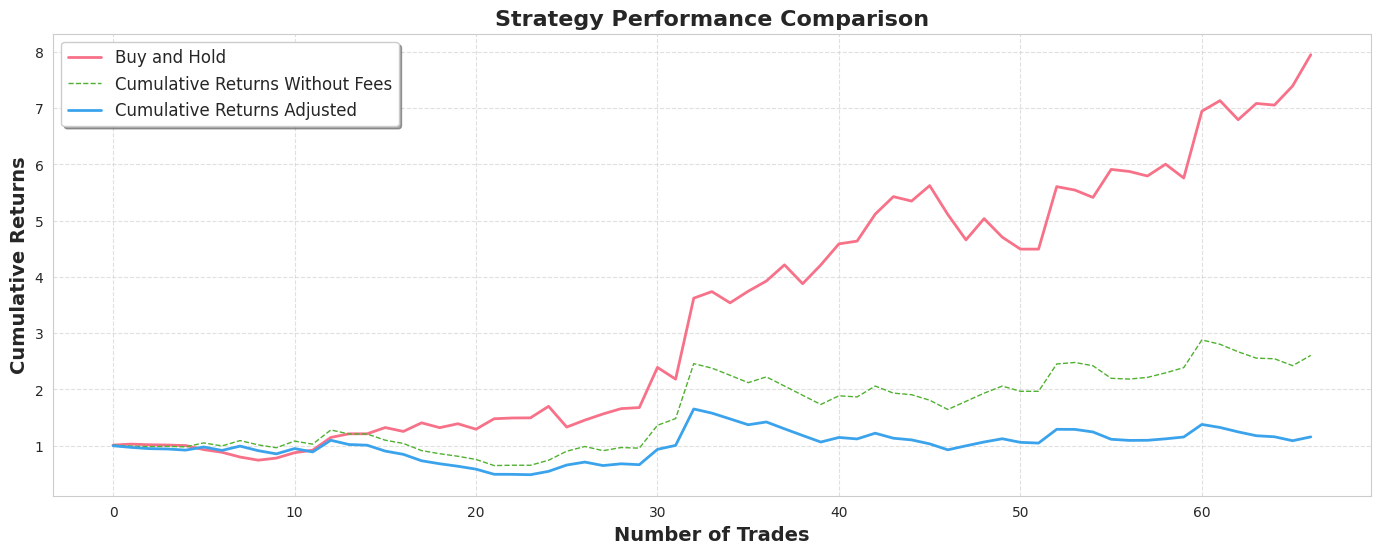

╒═══════════════════╤══════════╕
│ Metric            │    Value │
╞═══════════════════╪══════════╡
│ sharpe_ratio      │  1.10109 │
├───────────────────┼──────────┤
│ sortino_ratio     │  3.78646 │
├───────────────────┼──────────┤
│ treynor_ratio     │  3.28264 │
├───────────────────┼──────────┤
│ information_ratio │ -4.42204 │
├───────────────────┼──────────┤
│ sterling_ratio    │  8.37884 │
├───────────────────┼──────────┤
│ calmar_ratio      │  3.94198 │
╘═══════════════════╧══════════╛


In [7]:
"""Let's plot the results as operations bars."""
backtest.plot_operationsBars(by_date=False)
table = [(key, value) for key, value in operation_stats.items()]
print(tabulate(table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

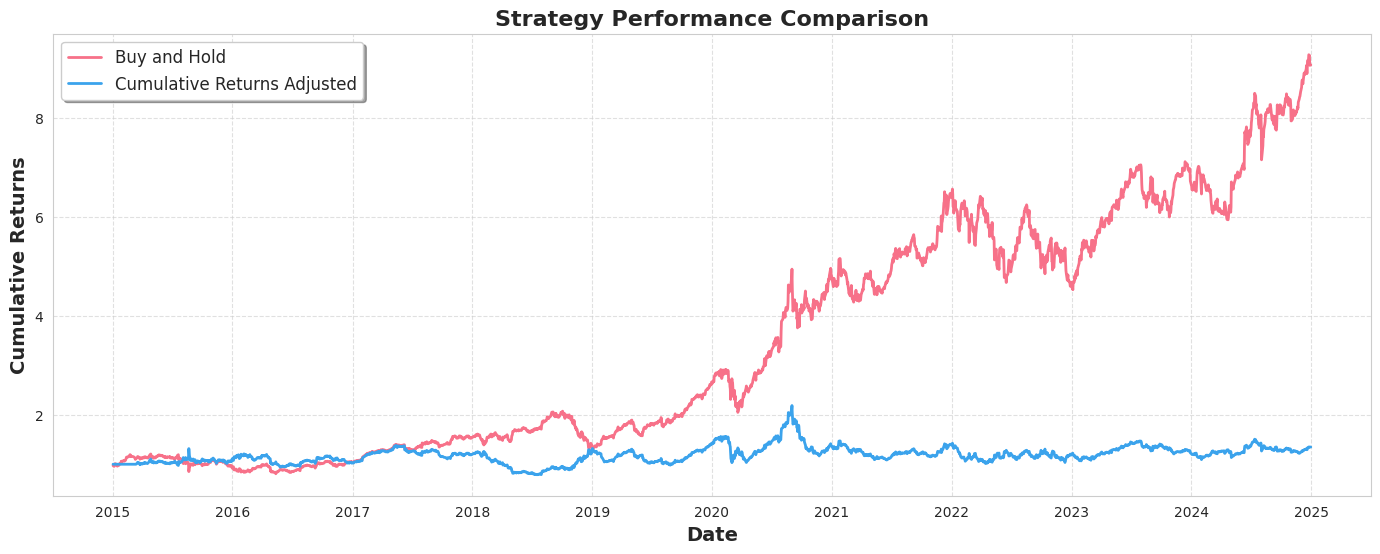

╒═══════════════════╤═══════════╕
│ Metric            │     Value │
╞═══════════════════╪═══════════╡
│ sharpe_ratio      │  0.248718 │
├───────────────────┼───────────┤
│ sortino_ratio     │  0.333027 │
├───────────────────┼───────────┤
│ treynor_ratio     │ -3.16787  │
├───────────────────┼───────────┤
│ information_ratio │ -0.457614 │
├───────────────────┼───────────┤
│ sterling_ratio    │  0.254357 │
├───────────────────┼───────────┤
│ calmar_ratio      │  0.135358 │
╘═══════════════════╧═══════════╛


In [8]:
"""Let's plot the results as time bars."""
backtest.plot_timeBars()
table = [(key, value) for key, value in time_stats.items()]
print(tabulate(table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

---
### **Bollinger Bands Strategy**

The **Bollinger Bands** strategy is a popular and effective tool among retail traders for identifying potential trading opportunities based on volatility.

**Key Points:**
- **Strategy Overview:** Bollinger Bands consist of a middle band (usually a simple moving average) and two outer bands (typically two standard deviations above and below the middle band). These bands create a volatility envelope around the price series, helping to identify overbought or oversold conditions.
- **Trading Signals:**
  - **Buy Signal:** Occurs when the price crosses below the lower band, indicating a potential oversold condition and a possible price rebound.
  - **Sell Signal:** Occurs when the price crosses above the upper band, suggesting a potential overbought condition and a possible price correction.
- **Backtesting:** We will simulate this strategy using historical data to assess its performance, focusing on how well it captures price reversals and manages risk.


In [9]:
"""
Let's define the average_features and volatility_features function used in the BollingerBands strategy.
"""
def average_features(
    price_series: pd.Series,
    window: int,
):
    # ======= I. Compute the different smoothed series =======
    rolling_average = price_series.rolling(window=window + 1).apply(lambda x: np.mean(x[:window]))

    # ======= II. Convert to pd.Series =======
    rolling_average = pd.Series(rolling_average, index=price_series.index)
    
    # ======= III. Change Name =======
    rolling_average.name = f"average_{window}"

    return rolling_average

def volatility_features(
    price_series: pd.Series,
    window: int,
):
    # ======= I. Compute the rolling adjusted volatility =======
    returns_series = price_series.pct_change().dropna()
    rolling_vol = returns_series.rolling(window=window + 1).apply(lambda x: np.std(x[:window]))

    # ======= II. Convert to pd.Series and Center =======
    rolling_vol = pd.Series(rolling_vol, index=price_series.index)
    
    # ======= III. Change Name =======
    rolling_vol.name = f"vol_{window}"

    return rolling_vol

#! ==================================================================================== #
#! ====================================== Strategy ==================================== #
class simple_BollingerBands(Strategy):
    def __init__(self):
        super().__init__()

        # ======= Strategy parameters =======
        self.window_ma = None
        self.window_vol = None
    
    #*____________________________________________________________________________________ #
    def set_params(self, window_ma: int, window_vol: int):
        """
        For this strategy, we need to set the windows of the moving averages.
        
            - window_big (int) : window of the big moving average
            - window_small (int) : window of the small moving
        """
        self.window_ma = window_ma
        self.window_vol = window_vol
    
    #*____________________________________________________________________________________ #
    def load_data(self, ticker: str, start_date: str, end_date: str):
        data = dt.load_data(ticker)
        data = data.loc[start_date:end_date]
        
        data['date'] = data.index
        data.reset_index(drop=True, inplace=True)

        self.data = data

        return data
    
    #*____________________________________________________________________________________ #
    def process_data(self):
        data = self.data.copy()
        close_series = data['close']

        moving_average = average_features(price_series=close_series, window=self.window_ma)
        volatility = volatility_features(price_series=close_series, window=self.window_vol)
        data['MA'] = moving_average
        data['Volatility'] = volatility

        data['upper_band'] = data['MA'] + data['Volatility'] * 2
        data['lower_band'] = data['MA'] - data['Volatility'] * 2

        processed_data = [data]

        self.processed_data = processed_data

        return processed_data
    
    #*____________________________________________________________________________________ #
    def fit(self):
        pass

    #*____________________________________________________________________________________ #
    def predict(self, df: pd.DataFrame):
        signals_df = df.copy()
        signals_df['signal'] = 0

        signals_df.loc[signals_df[self.bid_open_name] < signals_df['lower_band'], 'signal'] = 1
        signals_df.loc[signals_df[self.bid_open_name] > signals_df['upper_band'], 'signal'] = -1

        return signals_df

In [10]:
"""
That's it, we can now run the backtest and plot the results.
"""

backtest = Backtest(strategy=simple_BollingerBands(), brokerage_cost=0.002, slippage_cost=0.005)
backtest.set_computingParams(date_name='date', bid_open_name='open', ask_open_name='open')
backtest.set_backtestParams(ticker='AAPL', start_date='2015-01-01', end_date='2025-01-01', strategy_params={'window_ma': 20, 'window_vol': 20})
operations_df, signals_df, operation_stats, time_stats = backtest.run_backtest()
operations_df

,ID,Side,Entry_Date,Entry_Price,Exit_Date,Exit_Price,PnL,Entry_Price_Adjusted,Exit_Price_Adjusted,PnL_Adjusted,NoFees_strategy_returns,NoFees_strategy_cumret,strategy_returns,strategy_cumret,BuyAndHold_returns,BuyAndHold_cumret
0,0,-1,2015-02-04,29.6250,2015-03-11,31.1875,-1.5625,29.476875,31.343437,-1.925812,-0.052743,0.947257,-0.065006,0.934994,0.052743,1.052743
1,1,1,2015-03-11,31.1875,2015-03-20,32.0625,0.8750,31.343437,31.902188,0.496375,0.028056,0.973834,0.015916,0.949875,0.028056,1.082278
2,2,-1,2015-03-20,32.0625,2015-03-24,31.8075,0.2550,31.902188,31.966537,-0.128475,0.007953,0.981579,-0.004007,0.946069,-0.007953,1.073671
3,3,1,2015-03-24,31.8075,2015-03-25,31.6350,-0.1725,31.966537,31.476825,-0.553327,-0.005423,0.976256,-0.017396,0.929611,-0.005423,1.067848
4,4,1,2015-03-26,30.6900,2015-04-01,31.2050,0.5150,30.843450,31.048975,0.144145,0.016781,0.992638,0.004697,0.933977,0.016781,1.085767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,-1,2024-10-10,227.7800,2024-10-28,233.3200,-5.5400,226.641100,234.486600,-8.301060,-0.024322,0.078243,-0.036443,0.005467,0.024322,7.977946
216,216,1,2024-10-28,233.3200,2024-10-29,233.1000,-0.2200,234.486600,231.934500,-3.018740,-0.000943,0.078169,-0.012938,0.005396,-0.000943,7.970423
217,217,-1,2024-10-29,233.1000,2024-11-01,220.9650,12.1350,231.934500,222.069825,9.398475,0.052059,0.082239,0.040319,0.005614,-0.052059,7.555489
218,218,1,2024-11-01,220.9650,2024-11-21,228.8800,7.9150,222.069825,227.735600,5.223845,0.035820,0.085185,0.023641,0.005747,0.035820,7.826128


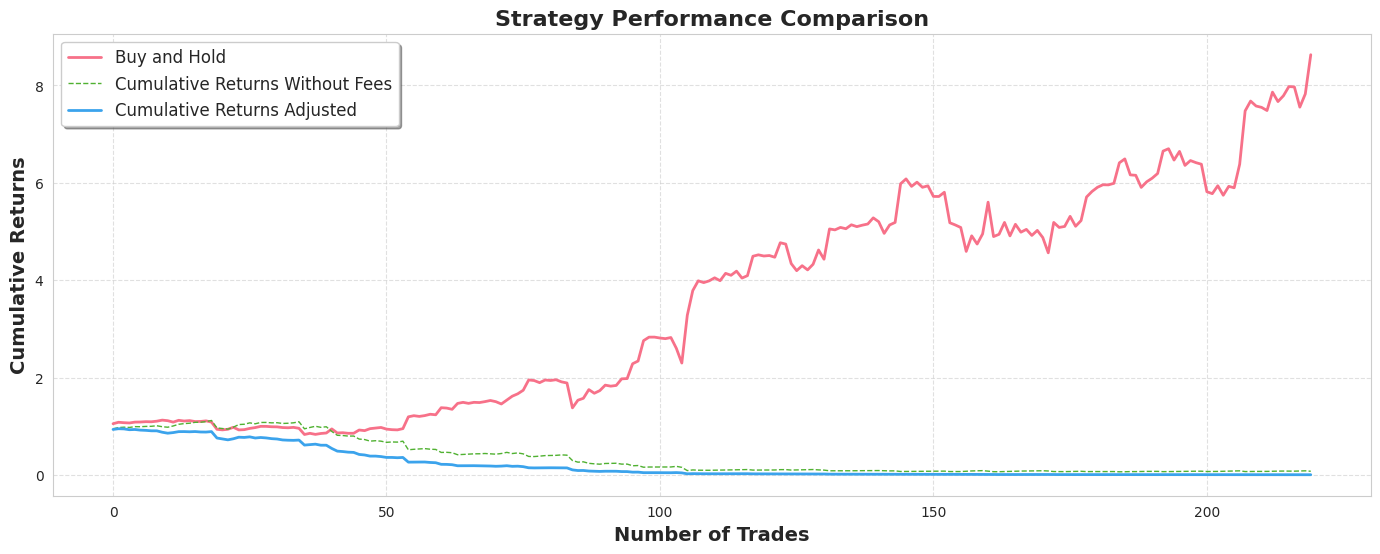

╒═══════════════════╤══════════╕
│ Metric            │    Value │
╞═══════════════════╪══════════╡
│ sharpe_ratio      │ -5.42885 │
├───────────────────┼──────────┤
│ sortino_ratio     │ -5.1535  │
├───────────────────┼──────────┤
│ treynor_ratio     │ 14.4594  │
├───────────────────┼──────────┤
│ information_ratio │ -5.08583 │
├───────────────────┼──────────┤
│ sterling_ratio    │ -6.89244 │
├───────────────────┼──────────┤
│ calmar_ratio      │ -5.43117 │
╘═══════════════════╧══════════╛


In [11]:
"""Let's plot the results as operations bars."""
backtest.plot_operationsBars(by_date=False)
table = [(key, value) for key, value in operation_stats.items()]
print(tabulate(table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

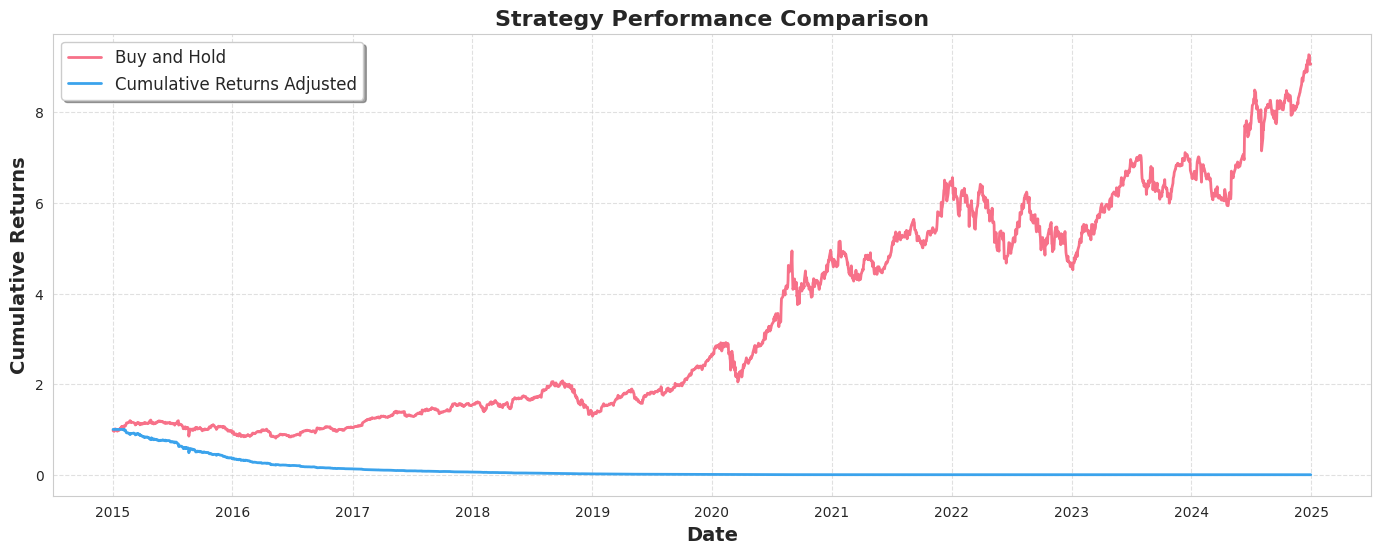

╒═══════════════════╤══════════╕
│ Metric            │    Value │
╞═══════════════════╪══════════╡
│ sharpe_ratio      │ -4.16326 │
├───────────────────┼──────────┤
│ sortino_ratio     │ -5.34592 │
├───────────────────┼──────────┤
│ treynor_ratio     │ -6.7767  │
├───────────────────┼──────────┤
│ information_ratio │ -3.89915 │
├───────────────────┼──────────┤
│ sterling_ratio    │ -1.29534 │
├───────────────────┼──────────┤
│ calmar_ratio      │ -1.17057 │
╘═══════════════════╧══════════╛


In [12]:
"""Let's plot the results as time bars."""
backtest.plot_timeBars()
table = [(key, value) for key, value in time_stats.items()]
print(tabulate(table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

---

### **Enhancing Strategy Performance**

We've observed that these simple strategies perform poorly with the current dataset. However, there's potential to improve their performance through **hyperparameter optimization**.

**Key Points:**
- **Current Observations:** The basic implementations of these strategies have not yielded satisfactory results, indicating a need for refinement.
- **Hyperparameter Optimization:** This process involves fine-tuning the parameters of our trading strategies to better fit the data and improve performance.


In [13]:
class opti_MAcrossover(Strategy):
    def __init__(self):
        super().__init__()

        # ======= Strategy parameters =======
        self.window_big = None
        self.window_small = None
    
    #*____________________________________________________________________________________ #
    def set_params(self, window_big: int, window_small: int):
        """
        For this strategy, we need to set the windows of the moving averages.
        
            - window_big (int) : window of the big moving average
            - window_small (int) : window of the small moving
        """
        self.window_big = window_big
        self.window_small = window_small
    
    #*____________________________________________________________________________________ #
    def load_data(self, ticker: str, start_date: str, end_date: str):
        data = dt.load_data(ticker)
        data = data.loc[start_date:end_date]
        
        data['date'] = data.index
        data.reset_index(drop=True, inplace=True)

        self.data = data

        return data
    
    #*____________________________________________________________________________________ #
    def process_data(self):
        data = self.data.copy()
        close_series = data['close']

        moving_average_big = average_features(price_series=close_series, window=self.window_big)
        moving_average_small = average_features(price_series=close_series, window=self.window_small)
        data['MA_big'] = moving_average_big
        data['MA_small'] = moving_average_small

        processed_data = [data]

        self.processed_data = processed_data

        return processed_data
    
    #*____________________________________________________________________________________ #
    def fit(self, ticker: str, start_date: str, end_date: str):
        params_grid = {
            "window_big": [50, 75, 100, 150, 200],
            "window_small": [5, 10, 20, 30, 40],
        }

        best_params = None
        best_sharpe = -np.inf

        for window_big in params_grid["window_big"]:
            for window_small in params_grid["window_small"]:
                backtest = Backtest(strategy=opti_MAcrossover(), brokerage_cost=0.002, slippage_cost=0.005)
                backtest.set_computingParams(date_name='date', bid_open_name='open', ask_open_name='open')
                backtest.set_backtestParams(ticker=ticker, start_date=start_date, end_date=end_date, strategy_params={'window_big': window_big, 'window_small': window_small})
                _, _, operations_stats, _ = backtest.run_backtest()
                sharpe = operations_stats['sharpe_ratio']

                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_params = {'window_big': window_big, 'window_small': window_small}
        
        self.set_params(**best_params)

        return best_params
        

    #*____________________________________________________________________________________ #
    def predict(self, df: pd.DataFrame):
        signals_df = df.copy()
        signals_df['signal'] = 0

        signals_df.loc[signals_df['MA_big'] < signals_df['MA_small'], 'signal'] = 1
        signals_df.loc[signals_df['MA_big'] > signals_df['MA_small'], 'signal'] = -1

        return signals_df

In sample results with best params found : {'window_big': 200, 'window_small': 30}


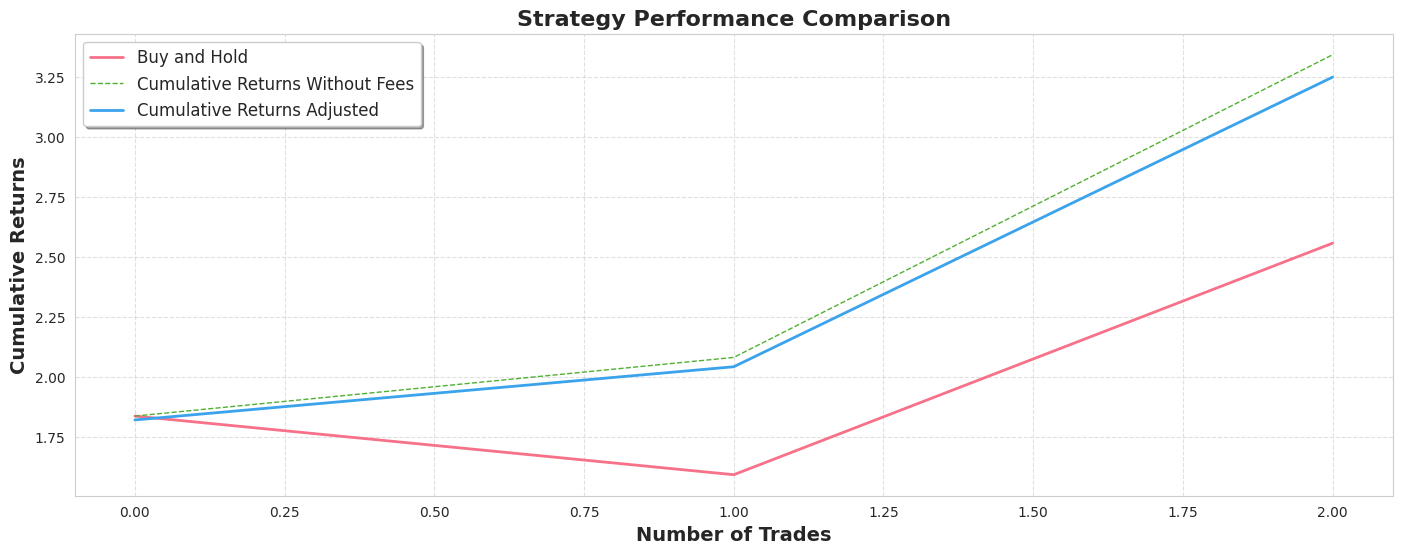

In [14]:
backtest = Backtest(strategy=opti_MAcrossover(), brokerage_cost=0.002, slippage_cost=0.005)
backtest.set_computingParams(date_name='date', bid_open_name='open', ask_open_name='open')

best_params = backtest.strategy.fit(ticker='AAPL', start_date='2010-01-01', end_date='2015-01-01')

backtest.set_backtestParams(ticker='AAPL', start_date='2010-01-01', end_date='2015-01-01', strategy_params=best_params)
operations_df, signals_df, operation_stats, time_stats = backtest.run_backtest()

print(f'In sample results with best params found : {best_params}')
backtest.plot_operationsBars(by_date=False)

Out of Sample results with best params found : {'window_big': 200, 'window_small': 30}


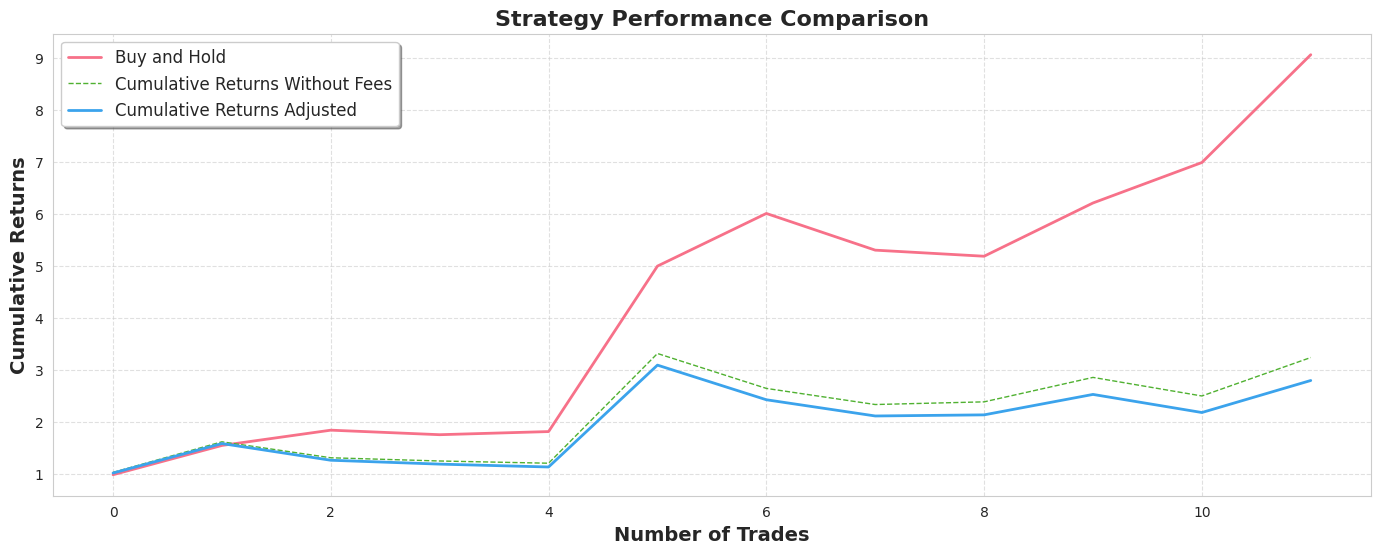

In [15]:
backtest.set_backtestParams(ticker='AAPL', start_date='2015-01-01', end_date='2025-01-01', strategy_params=best_params)
operations_df, signals_df, operation_stats, time_stats = backtest.run_backtest()

print(f'Out of Sample results with best params found : {best_params}')
backtest.plot_operationsBars(by_date=False)